# Word2Vec - CBoW 구현

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
import string
from tqdm import tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 조사, 접속사, 불용어 제거 후 토큰화 및 원핫인코딩

In [10]:
doc = "you will never know until you try."

pos_unused = ['CC', 'DT']
stopwords = list(string.punctuation)
words = pos_tag(word_tokenize(doc))
words = [w[0] for w in words if w[1] not in pos_unused and w[0] not in stopwords]
token = np.unique(words)

one_hot = {}
for i, word in enumerate(token):
    one_hot[word] = np.eye(len(token))[i]

In [11]:
words

['you', 'will', 'never', 'know', 'until', 'you', 'try']

In [12]:
one_hot

{'know': array([1., 0., 0., 0., 0., 0.]),
 'never': array([0., 1., 0., 0., 0., 0.]),
 'try': array([0., 0., 1., 0., 0., 0.]),
 'until': array([0., 0., 0., 1., 0., 0.]),
 'will': array([0., 0., 0., 0., 1., 0.]),
 'you': array([0., 0., 0., 0., 0., 1.])}

## 학습 과정

In [13]:
N_window = 2 # 앞, 뒤로 보는 단어 수
N_dim = 4 # 축소된 차원 수
alpha = 0.01
epoch = 10000
losses_epoch = []

W1 = np.random.random_sample((len(token), N_dim))
W2 = np.random.random_sample((N_dim, len(token)))

def softmax(v):
    return np.exp(v) / sum(np.exp(v))

for e in tqdm(range(epoch)):
    losses = []
    for i, word in enumerate(words):
        output_vec = one_hot[word]
        input_vec = []

        for j in range(1, N_window+1):
            if i-j >= 0:
                input_vec.append(one_hot[words[i-j]]) # 전 단어
            try: input_vec.append(one_hot[words[i+j]]) # 후 단어
            except: pass
        
        H = []
        for j in range(len(input_vec)):
            H.append(np.dot(input_vec[j], W1))
        H = np.sum(H, axis=0) / len(input_vec) # 모든 window 속 단어들의 평균값

        pred = softmax(np.dot(H, W2))

        loss = -np.dot(output_vec, np.log(pred).reshape(len(pred), 1))
        losses.extend(loss)
        
        gradient_W2 = np.dot(H.reshape(len(H), 1), (pred-output_vec).reshape(1, len(pred)))
        gradient_W1 = np.dot(input_vec[j].reshape(len(input_vec[j]), 1), np.dot(W2, (pred-output_vec)).reshape(1, len(W2)))
        
        W2 -= alpha * gradient_W2
        W1 -= alpha * gradient_W1
    
    losses_epoch.append(np.sum(losses))

100%|██████████| 10000/10000 [00:11<00:00, 903.30it/s]


## 학습 과정 중 Loss 시각화

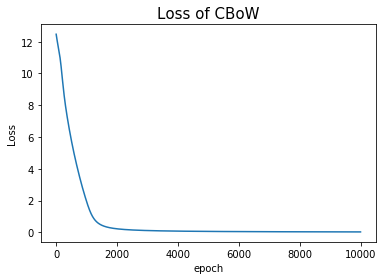

In [14]:
plt.plot(np.arange(epoch), losses_epoch)
plt.title("Loss of CBoW", size=15)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

## W1을 이용한 벡터간 유사도 측정

In [15]:
pd.DataFrame(W1, index = token)

,0,1,2,3
know,5.632946,2.055743,6.972249,-4.656097
never,1.710759,5.502793,1.833999,-1.177893
try,4.295551,2.956859,-7.896700,1.175519
until,-12.272807,-6.086469,2.784612,-5.657116
will,0.192340,0.258421,0.690542,0.146668
you,3.810372,5.795173,-2.024013,11.919070


In [16]:
simmilarity_minus = {} 
for i in range(len(token)):
    tmp = []
    for j in range(len(token)):
        simmilarity = np.dot(W1[i], W1[j]) / np.linalg.norm(W1[i]) * np.linalg.norm(W1[j])
        tmp.append(-simmilarity) # 순서 정렬을 위해 음수 처리
    simmilarity_minus[token[i]] = tmp

N_simmilar = 3
simmilarity_df = {}
for i, t in enumerate(token):
    tmp = np.argsort(simmilarity_minus[t]) # 순서대로 유사도가 높은 것
    simmilarity_df[t] = token[np.delete(tmp, np.where(tmp == i))][:N_simmilar] # 같은 단어 출력 방지

In [379]:
pd.DataFrame(simmilarity_df)

,know,never,try,until,will,you
0,never,know,you,will,know,try
1,will,you,will,know,you,never
2,try,will,never,never,never,will


## 정확도 측정
1번째 단어 - 2번째 단어 + 3번째 단어 벡터와 가장 유사한 벡터가 4번째 단어인지 확인

In [24]:
accuracy = 0
for i in range(len(words)-3):
    
    word_1 = np.where(token == words[i])
    word_2 = np.where(token == words[i+1])
    word_3 = np.where(token == words[i+2])
    
    w = W1[word_1] - W1[word_2] + W1[word_3]

    simmilar_w = []
    for j, t in enumerate(token):
        tmp = np.dot(w, W1[j]) / np.linalg.norm(w) * np.linalg.norm(W1[j])
        simmilar_w.append(tmp)
    accuracy += (token[np.argmax(simmilar_w)] == words[i+3]) * 1

accuracy = accuracy / (len(words)-3) * 100
print(accuracy, "%") # 결과가 처참함

0.0 %


# Class

In [31]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
import string
from tqdm import tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class CBoW:
    def __init__(self, doc, N_dim, N_window, alpha, epoch):
        self.doc = doc
        self.N_dim = N_dim
        self.N_window = N_window
        self.alpha = alpha
        self.epoch = epoch

    def _tokenize(self):
        pos_unused = ['CC', 'DT']
        stopwords = list(string.punctuation)
        words = pos_tag(word_tokenize(self.doc))
        words = [w[0] for w in words if w[1] not in pos_unused and w[0] not in stopwords]
        token = np.unique(words)
        self.token = token
        self.words = words
        return words, token

    def _init_weight(self):
        W1 = np.random.random_sample((len(self.token), self.N_dim))
        W2 = np.random.random_sample((self.N_dim, len(self.token)))
        return W1, W2

    def _onehot_encoding(self):
        one_hot = {}
        for i, word in enumerate(self.token):
            one_hot[word] = np.eye(len(self.token))[i]
        return one_hot
    
    def _softmax(self, v):
        return np.exp(v) / sum(np.exp(v))

    def optimize(self):
        words, token = self._tokenize()
        one_hot = self._onehot_encoding()
        W1, W2 = self._init_weight()
        losses_epoch = []

        for e in tqdm(range(self.epoch)):
            losses = []
            for i, word in enumerate(words):
                output_vec = one_hot[word]
                input_vec = []

                for j in range(1, self.N_window+1):
                    if i-j >= 0:
                        input_vec.append(one_hot[words[i-j]]) # 전 단어
                    try: input_vec.append(one_hot[words[i+j]]) # 후 단어
                    except: pass
                
                H = []
                for j in range(len(input_vec)):
                    H.append(np.dot(input_vec[j], W1))
                H = np.sum(H, axis=0) / len(input_vec) # 모든 window 속 단어들의 평균값

                pred = self._softmax(np.dot(H, W2))

                loss = -np.dot(output_vec, np.log(pred).reshape(len(pred), 1))
                losses.extend(loss)
                
                gradient_W2 = np.dot(H.reshape(len(H), 1), (pred-output_vec).reshape(1, len(pred)))
                gradient_W1 = np.dot(input_vec[j].reshape(len(input_vec[j]), 1), np.dot(W2, (pred-output_vec)).reshape(1, len(W2)))
                
                W2 -= self.alpha * gradient_W2
                W1 -= self.alpha * gradient_W1
            
            losses_epoch.append(np.sum(losses))
        
        self.W1 = W1
        self.W2 = W2
        self.losses_epoch = losses_epoch

    def plot(self):    
        plt.plot(np.arange(self.epoch), self.losses_epoch)
        plt.title("Loss of CBoW", size=15)
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.show()
    
    def token_vector(self):
        return pd.DataFrame(self.W1, index = self.token)
    
    def similar_tokens(self, N_similar):
        similarity_minus = {}
        similarity_df = {}

        for i in range(len(self.token)):
            tmp = []
            for j in range(len(self.token)):
                similarity = np.dot(self.W1[i], self.W1[j]) / np.linalg.norm(self.W1[i]) * np.linalg.norm(self.W1[j])
                tmp.append(-similarity) # 순서 정렬을 위해 음수 처리
            similarity_minus[self.token[i]] = tmp

        for i, t in enumerate(self.token):
            tmp = np.argsort(similarity_minus[t]) # 순서대로 유사도가 높은 것
            similarity_df[t] = self.token[np.delete(tmp, np.where(tmp == i))][:N_similar] # 같은 단어 출력 방지
        
        return pd.DataFrame(similarity_df)

    def accuracy(self):
        accuracy = 0
        for i in range(len(self.words)-3):
            word_1 = np.where(self.token == self.words[i])
            word_2 = np.where(self.token == self.words[i+1])
            word_3 = np.where(self.token == self.words[i+2])
            
            w = self.W1[word_1] - self.W1[word_2] + self.W1[word_3]

            simmilar_w = []
            for j, t in enumerate(self.token):
                tmp = np.dot(w, self.W1[j]) / np.linalg.norm(w) * np.linalg.norm(self.W1[j])
                simmilar_w.append(tmp)
            accuracy += (self.token[np.argmax(simmilar_w)] == self.words[i+3]) * 1

        accuracy = accuracy / (len(self.words)-3)
        return accuracy

In [34]:
doc = "you will never know until you try."
cb = CBoW(doc, 4, 2, 0.01, 10000)
cb.optimize()

100%|██████████| 10000/10000 [00:09<00:00, 1037.87it/s]


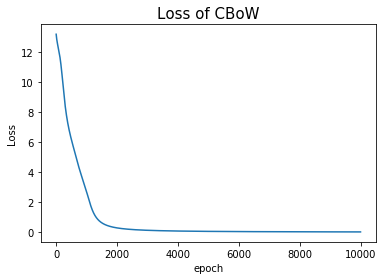

In [36]:
cb.plot()

In [37]:
cb.token_vector()

,0,1,2,3
know,6.627509,-9.992556,2.224918,0.721019
never,1.108791,-1.359338,3.985075,3.054271
try,-6.914271,-0.833182,-0.908138,4.175713
until,3.207990,9.643547,3.634265,-11.063367
will,0.403032,0.039901,0.155400,0.942370
you,-1.864726,4.113944,-2.410190,12.421427


In [38]:
cb.similar_tokens(3)

,know,never,try,until,will,you
0,never,know,you,will,you,try
1,will,you,never,never,know,never
2,try,try,will,try,never,will


In [39]:
cb.accuracy()

0.0